<center><h1>Investment returns, portfolios, and indexes</h1></center>

<center>William Mann</center>

<center>
<img src="https://wgjm1986.github.io/FIN323/Emory_small.png" height="200px" width="300px" />
</center>

# Code to download data used in the figures in these slides.
(The code to actually generate the figures appears later.)

In [1]:
# Import packages
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import wrds
from fredapi import Fred
import math
import statsmodels.formula.api
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16.0, 8.0]
from statistics import median
from scipy.stats import skew

import os
from dotenv import load_dotenv
load_dotenv();

In [2]:
# Open WRDS connection
conn = wrds.Connection(wrds_username=os.environ['WRDS_USERNAME'])

Loading library list...
Done


In [3]:
# Download daily returns on S&P 500 stocks over the last 30 years
sp500_daily = conn.raw_sql("""
    select a.*, b.date, b.ret
    from crsp.msp500list as a
    join (
        select permno, date, ret
        from crsp.dsf
        where date >= '01/01/1995' and date <= '12/31/2024'
    ) as b
    on a.permno = b.permno
    where b.date >= a.start and b.date <= a.ending
    order by b.date;
    """, date_cols=['start', 'ending', 'date'])

In [4]:
# Download monthly returns on S&P 500 stocks
sp500_monthly = conn.raw_sql("""
    select a.*, b.date, b.ret
    from crsp.msp500list as a
    join crsp.msf as b on a.permno = b.permno
    where b.date >= a.start and b.date <= a.ending
    and b.date >= '01/01/1995' and b.date <= '12/31/2024'
    order by b.date;
    """, date_cols=['start', 'ending', 'date'])

In [5]:
# Download data on S&P 500 index returns
SP500 = conn.raw_sql("select caldt, spindx, vwretd, vwretx, ewretd, ewretx from crsp_a_indexes.msp500")
SP500['month'] = pd.to_datetime(SP500['caldt']).dt.to_period('M')
SP500 = SP500.drop(columns=['caldt']).set_index(['month'])
SP500 = SP500['1995':'2024']

In [6]:
# Download total return and price return on the iShares AGG ETF as a proxy for the Bloomberg Agg index
sql = """
    select m.permno, m.date, m.prc, m.ret, m.retx
    from crsp.msf m
    where m.permno = 89848
    order by m.date;
"""
AGG = conn.raw_sql(sql)
AGG['date'] = pd.to_datetime(AGG['date'])
AGG.set_index('date',inplace=True)

In [7]:
# Close WRDS connection
conn.close()

<center><h2>Returns on investing in Treasuries</h2></center>

Specifically, we will look at the returns on *zero-coupon* Treasuries. (Do you remember why?)

### Interest rate risk

- The yield on a zero-coupon bond is a risk-free rate of return, *if you hold the bond to maturity.*
- But if you need to sell at any point before then, there is no guarantee what the sale price will be.
- As interest rates move around, the price of your zero-coupon bond will move too, even though you know exactly how much it will pay in the future.
- This type of risk is called "interest rate risk," and it can be very large even for a "risk-free" bond!
- In this sense, long-term Treasuries can be a very risky investment over short horizons.
- On the other hand, interest rate risk is negligible for the shortest-maturity Treasuries (1m and 3m). That is why these are called "cash equivalent".

### Investing in Treasuries over the last ten years

- To illustrate, let's consider two different ways you could have invested in Treasuries over the last ten years.
- Idea #1: Buy a ten-year zero-coupon bond on January 1, 2015. Hold until it matures.
    - The initial yield to maturity was 2.3735%.
    - Compound this over 10 years: $1.023735^{10} = 1.2644374$.
    - That is, each \\$1 invested initially would be worth \\$1.26 by the end of 2024.
- Idea #2: Buy a one-month bill on January 1, 1995. When it matures the next month, buy another, and so on.
    - The yield in January was 0.03%. This is already annualized! The yield *during* January was $1.0003^{1/12}$.
    - The yield in February was 0.02%. By the end of February an initial dollar was worth $1.0003^{1/12}\times 1.0002^{1/12}$. And so on.
    - By the end of 2024 an initial \\$1 invested would be worth \\$1.19.
- We can imagine many other ideas as well, but let's just look at these two.

### Comparison

In [8]:
%%capture

START = pd.Timestamp("2015-01-01")
START7 = START-pd.Timedelta(weeks=1)
END   = pd.Timestamp("2024-12-31")

# Fetch data from FRED
fred = Fred()
# Short T-bill anchors (these are effectively zero-coupon instruments)
def fred_series(series_id, start=START7, end=END):
    s = fred.get_series(series_id, observation_start=start.date(), observation_end=end.date())
    s = s.to_frame(series_id)
    s.index = pd.to_datetime(s.index)
    return s

short_ids = ["DGS1MO", "DGS3MO", "DGS6MO"]
tenor_ids = [f"THREEFY{n}" for n in range(1, 11)]
raw = pd.concat( [fred_series(sid) for sid in short_ids+tenor_ids] , axis=1)

biz_idx_7 = pd.date_range(START7, END, freq="B")
biz_idx = pd.date_range(START, END, freq="B")
cal_idx_7 = pd.date_range(START7, END, freq="D")
cal_idx = pd.date_range(START, END, freq="D")

# Forward-fill to cover business/calendar days cleanly
raw_biz = raw.reindex(biz_idx_7).ffill()
raw_cal = raw.reindex(cal_idx_7).ffill()

# -----------------------------
# Strategy A: Roll 1-month T-bill (daily accrual on calendar days)
# -----------------------------
# Pull DGS1MO on business days
dgs1mo_biz = raw_biz[["DGS1MO"]].astype(float)
# First business day of each month (Business Month Start)
month_starts = pd.date_range(START, END, freq="BMS")
# Get the 1M yield observed on the earliest business day of each month
monthly_rates = dgs1mo_biz.reindex(month_starts, method="ffill").loc[month_starts, "DGS1MO"]
# Cumulate these monthly returns over our time series
monthly_cumulative = ( ( 1 + monthly_rates/100 )**(1/12) ).cumprod()
# Resample this back to daily; I'm cheating a little by interpolating instead of actually discounting within-month but it makes very little difference
roll_idx_cal = monthly_cumulative.reindex(cal_idx).interpolate("time")
# Rescale by the initial value
roll_idx_cal /= roll_idx_cal.iloc[0]
# Reindex to the same dates as we will use with the STRIP series later
roll_1m_idx = roll_idx_cal.reindex(biz_idx)

# -----------------------------
# Strategy B: Buy a 10-year STRIP at start, price daily via interpolation
# -----------------------------
# Interpolation knots (in years) and corresponding columns
# 0y anchor -> 0% yield; then 1m, 3m, 6m bills; then 1..10y fitted zeroes
mats_years = np.array([0.0, 1/12, 3/12, 6/12] + list(range(1, 11)), dtype=float)
col_order  = ["ZERO0", "DGS1MO", "DGS3MO", "DGS6MO"] + tenor_ids

# Build a DataFrame with those columns (insert ZERO0 = 0)
curves = raw.reindex(biz_idx_7).ffill().reindex(biz_idx)

curves["ZERO0"] = 0.0
curves = curves[col_order]

dates = []
prices = []
for dt, row in curves.iterrows():
    tau = (END - pd.Timestamp(dt)).days / 365.25
    tau = min(tau,10) # just in case we exceed 10 years by a day or two
    z_tau = np.interp(tau, mats_years, row)
    z_pct = z_tau / 100
    price = 1 / ((1 + z_pct)**tau)
    dates.append(dt)
    prices.append(price)

strip10_idx = pd.Series(prices,index=dates,name="strip10_idx").sort_index()
strip10_idx /= strip10_idx.iloc[0]

# -----------------------------
# Combine & plot
# -----------------------------
plot_df = pd.DataFrame({
    "10 year STRIP market value": strip10_idx,
    "1-month T-bill strategy value": roll_1m_idx
}).dropna()

Treasuries_figure,ax = plt.subplots()
plt.figure(figsize=(10, 6))
plot_df.plot(ax=ax,
            title="Comparing strategies in Treasuries",
            xlabel="Date",
            ylabel="Market value per initial dollar")

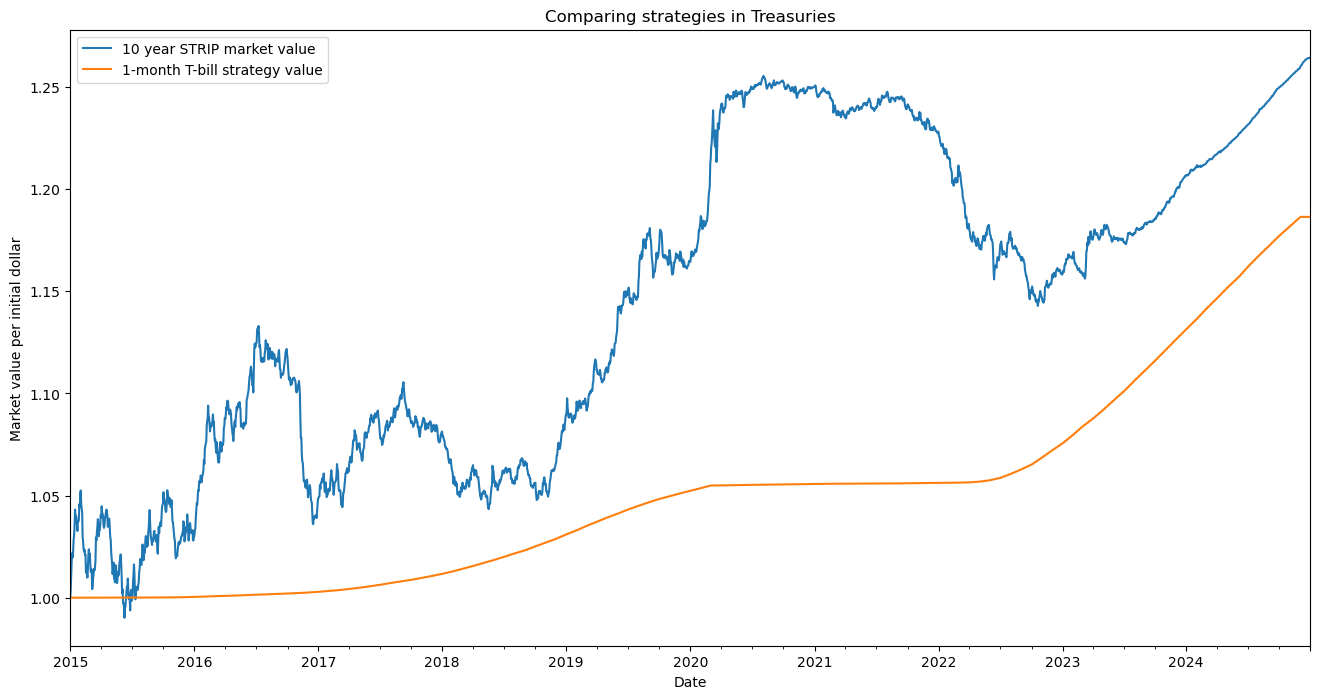

In [9]:
Treasuries_figure

### Takeaways

- We will always want to compare risky investments with some kind of risk-free benchmark.  
  But you can see that it's not so obvious what that benchmark should be.
- If you are investing for a goal ten years away, it might seem that the ten-year STRIP is the risk-free return.
    - It will generate a definite payoff in ten years, even if its price will fluctuate before then.
    - By contrast, you could *not* have been sure in advance that the strategy of buying 1-month bills would end up where it did.
- But you could also think of the next ten years as a *sequence* of short-term decisions: Every month, or even every day, you have the chance to revisit your decisions and adjust your portfolio.
    - From this perspective, you should approach each of these short-term decisions with the goal of leaving yourself the most possible wealth at the next date.
    - And then the natural way to analyze investments is at a high frequency, with a short-term yield (1 to 3 months) as the risk-free rate, and viewing the long-term STRIP as a *risky* investment due to its price fluctuations.
- This is always a controversial topic! But most finance theory takes the second perspective, and we will too.
    - This is why our risk-free rates will usually come from short-term Treasuries

### Excess returns

- The **excess return** on an investment over some horizon, is its return minus the risk-free rate of return that was available *during the same horizon*.
    - When we need to be clear, we will label a non-excess return as the **raw return**.
- As described earlier, we will usually view even long-term investments as a sequence of short-term horizons, and so the risk-free rate will also be from a short horizon.
- Note that inflation cancels out of excess returns because it affects both the risky and risk-free investment.


<center><h2>Returns on investing in the stock market</h2></center>

### Payout and returns on a single stock

- Payout comes in two types: Dividends, and share repurchases.
- In either case, the firm's book value of equity, and its market cap, both fall by the total amount of the payout.
    - With dividends, each share's market price and book value fall by exactly the amount of the dividend.
    - With repurchases, the total amount of shares outstanding decreases, while their individual share prices and book values do not change.
- Keep these points in mind as we look at the return calculations in the next few slides...

### Measuring individual stock returns

The return on a stock between dates 1 and 2, ignoring taxes, is

$$
r = \frac{P_2 + D}{P_1} -1 
$$

where $D$ represents all dividends paid between those dates.

Suppose you purchase a stock for \\$10 in January, the stock pays a dividend of \\$1 during the following year, and you sell the stock for \\$12 in December.

$$
r = \frac{\$12 + \$1}{\$10} - 1 = 30\%
$$

### Capital gains and dividend yield

The return calculation from the previous slide has two pieces:

$$
r = 
\underbrace{
\frac{P_2}{P_1} - 1
}_{\text{Capital gain}}
+
\underbrace{
\frac{D}{P_1}
}_{\text{Dividend yield}}
$$

- Capital gain is the return just from price increases.
- Dividend yield is an extra percentage income from dividends.
- If the company repurchases stock instead of paying a dividend, then the dividend yield is lower but the capital gain is higher.
- There is no reason for an investor to prefer one source of return over the other...except for a potential tax detail: see next slide.

### One tax effect worth knowing

We will mostly ignore tax issues, and focus on before-tax returns.
- Taxes are irrelevant for investors with tax-deferred accounts.
- For taxable investors, the exact effects vary greatly depending on the person.

However, one tax issue will come up later in Module 1:
- Capital gains are taxable when realized (when you sell).
- Dividends are taxable when paid, even if you did not want them.
- Thus, dividends can be inconvenient for taxable investors, if paid in a year when the investor has a high income tax bracket.
- This is a major reason behind the trend towards repurchases, and also behind the growth of ETFs.

### What's a "typical" monthly stock return?

<center>
<img src="https://wgjm1986.github.io/FIN323/Module%201/Week%202%20-%20Investment%20returns,%20portfolios,%20and%20indexes/bessembinder_2a_close.png" width="1000px" />
</center>

## More motivation: Returns on S&P 500 stocks

Let's revisit Bessembinder's point with a slightly different dataset:  

The S&P 500 is a list of companies maintained by Standard and Poors, and roughly corresponds to the 500 largest companies by market capitalization.  
It captures the vast majority of the market without tracking of thousands of stocks.

Here we look at daily returns, since 1980, on the stocks in the S&P 500 at any moment.  
We again see that the average return is high, but the median return is close to zero.  

Why do we care? Because it is very hard to learn much about such heavily skewed data.

In [10]:
print("Mean daily return on S&P 500 stocks: "
      f"{ 100*sp500_daily['ret'].mean() :.2f}%")
print(f"  (Annualized: { 250*100*sp500_daily['ret'].mean() :.2f}%)")
print("Median daily return on S&P 500 stocks: "
      f"{ 100*sp500_daily['ret'].median() :.2f}%")
print(f"  (Annualized: { 250*100*sp500_daily['ret'].median() :.2f}%)")

Mean daily return on S&P 500 stocks: 0.05%
  (Annualized: 13.29%)
Median daily return on S&P 500 stocks: 0.02%
  (Annualized: 5.17%)


## Average returns across S&P 500 stocks

However, most investors own many stocks and thus get an average return.  
And average returns show less of the extreme skewness that we saw earlier:

In [11]:
sp500EW_daily = sp500_daily.groupby('date')['ret'].mean()
print("Mean of average daily return: "
      f"{100*sp500EW_daily.mean() :.2f}%")
print(f"  (Annualized: {250*100*sp500EW_daily.mean() :.2f}%)")
print("Median of average daily return: "
      f"{100*sp500EW_daily.median() :.2f}%")
print(f"  (Annualized: {250*100*sp500EW_daily.median() :.2f}%)")

Mean of average daily return: 0.05%
  (Annualized: 13.29%)
Median of average daily return: 0.08%
  (Annualized: 21.13%)


In [12]:
sp500EW_monthly = sp500_monthly.groupby('date')['ret'].mean()
print("Mean of average monthly return: "
      f"{100*sp500EW_monthly.mean() :.2f}%")
print(f"  (Annualized: {12*100*sp500EW_monthly.mean() :.2f}%")
print("Median of average monthly return: "
      f"{100*sp500EW_monthly.median() :.2f}%")
print(f"  (Annualized: {12*100*sp500EW_monthly.median() :.2f}%")

Mean of average monthly return: 1.06%
  (Annualized: 12.74%
Median of average monthly return: 1.34%
  (Annualized: 16.05%


### Start by studying stock portfolios, not individual stocks.

- You might think that we would start studying the stock market by looking at individual stocks.
- But, as the earlier example shows, this would be a very tricky thing to do.
    - Stock returns are incredibly skewed.
    - At any moment, the entire return on the market is driven by just a few stocks.
- It would also fail to reflect what most investors actually do.
    - The average investor spreads their capital across broad portfolios of stocks.
    - In doing so, they earn *average* returns that are (somewhat) easier to study.
- We will also start out by studying stock portfolios and average returns.
    - This will get at the returns to investing in "the stock market," not just individual stocks.
- But what kind of portfolios, and what kind of average? That's our next topic.
    - To preview, the most important strategy and average will be a *value-weighted* one.
    - We will explain what this means, and why it is so important.

## Specific strategies and their portfolios

We will focus on three strategies an investor could use to build a portfolio:  
- Price weighting: Assets are weighted by their market price.
- Equal weighting: Assets all receive equal weight in the portfolio.
- Value weighting: Assets are weighted by total supply. (For stocks, by market cap.)
- These are not the only possibilities, but they are common and a good place for us to start.
  

In each case, using some example data, we will ask:

- How to form a portfolio reflecting that strategy?
- How to compute the return on that portfolio?
- How to rebalance the portfolio to stay in line with the strategy?
- What is the connection with the return on an index?

All the ideas apply to any asset class, but are easiest to describe with stocks.
- Later we will say a few words about applying these ideas to fixed income.

## Takeaways

We will see that the answers to the previous questions depend on:

- The price change of each security in the portfolio,
- The payout of each security (dividends, coupons, etc),
- Changes in the total supply of each investment (for example, stock splits, stock dividends, repurchases).

Most importantly, we will see why value-weighting is always the natural benchmark.

Homework 1 builds on these examples.

## Building and rebalancing a portfolio

A portfolio is just a collection of securities. To build one:

- Decide on the list of securities you want to include.
- Choose a strategy for how much to allocate to each one.
- Calculate the amounts you need to buy at current market prices.

After building a portfolio, you might also want to rebalance regularly, in order to stay in line with the strategy you chose above:

- Recalculate the portfolio that now aligns with your strategy, based on the new prices of each security and any other events that have happened.
- Buy or sell enough of each individual security to arrive at this desired portfolio.

## Measuring portfolio returns

The return on a portfolio between two dates can be calculated as:

- The ending value of securities owned and dividends received, divided by the initial value of the securities, minus 1;

- or, the weighted average return of each individual security, being sure to include the dividends that they paid, where the weights are the portfolio’s initial dollar allocations.

Either method will give the same answer.

### Keeping track of trading activity during rebalancing

Different strategies require different amounts of trading to rebalance.  
It is important to track this activity because trading is costly.

**Turnover** during any time is gross trading activity, as a percent of starting portfolio size. 

(To be clear, the exact trading costs are still only a fraction of this amount, and depend greatly on who is doing the trading.)

**Gross trading activity** is total purchases *plus* total sales. 

(We add them together because both are costly.)

For comparison, **net trading activity** is purchases *minus* sales. 

(This does not measure trading costs, but is still useful: It must equal the amount added or withdrawn from the portfolio, plus reinvestment of dividends or coupons.)

## Example 1: Textbook table 2.2, page 46

| Stock | Initial price | Final price | Shares (m) | Initial market cap (\$m) | Final market cap (\$m) |
|-------|---------------|-------------|------------|--------------------------|------------------------|
| ABC   | \$25          | \$30        | 20         | \$500                    | \$600                  |
| XYZ   | \$100         | \$90        | 1          | \$100                    | \$90                   |

## Example 2: Data on AMGN and GILD from 2017

| Stock | Initial price | Final price | Initial shares (m) | Final shares (m) | Dividends paid per share, \$ |
|-------|---------------|-------------|--------------------|------------------|------------------------------|
| AMGN  | \$146.21      | \$173.90    | 738.2              | 722.2            | \$4.60                       |
| GILD  | \$71.61       | \$71.64     | 1310               | 1308             | \$2.08                       |

## Importance of the value-weighted portfolio

Earlier on, we looked at simple average returns across stocks.  
As we have now seen, these averages match the return on an *equal-weighted* portfolio. 

But most investors in fact hold a *value-weighted* portfolio. This portfolio represents the "market return" and a "passive strategy", and is the benchmark for everything else.

This may seem surprising, but the value-weighted portfolio has many special features:
- It represents a proportional slice of the overall market. This means it is the only strategy that *everyone* can hold, and also that it requires the least rebalancing.
- It is *guaranteed* to match the overall market return. Any performance you gain or lose with a different portfolio is offset by the rest of the market.
- Although it weights *companies* very unevenly, it diversifies equally across dollars of expected future *profits*.

## Performance of the value-weighted S&P 500 portfolio since 1995

In [13]:
%%capture
# Build figures of S&P 500 index and S&P 500 total return index
SP500_cumulative_return = (1+SP500.vwretd).cumprod();
Market_return_figure,ax = plt.subplots();
SP500_cumulative_return.plot(ax=ax);
ax.set_ylabel("Growth of $1 in a value-weighted portfolio \n of all S&P 500 stocks (reinvesting dividends)")

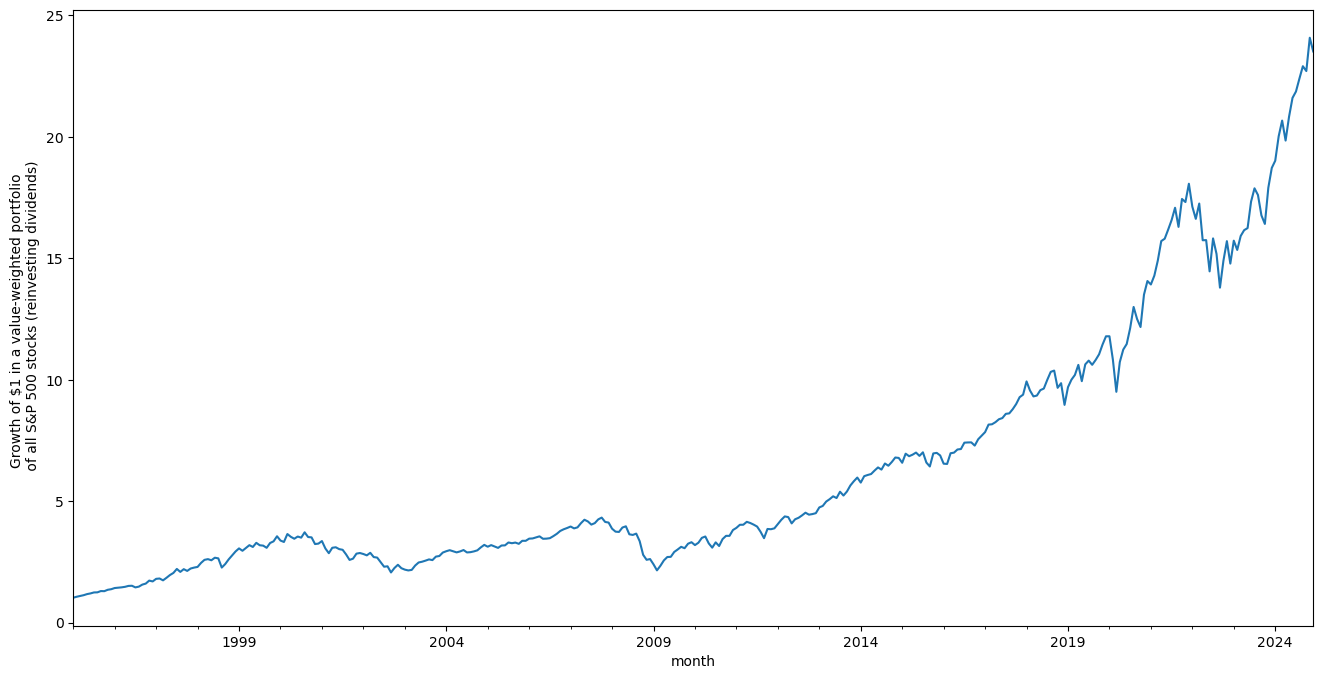

In [14]:
Market_return_figure

## Indexes of investment performance

An index helps track the performance of a given strategy/portfolio.

Examples:

- **DJIA**: price-weighted portfolio of stocks.
- **S\&P 500 index**: value-weighted portfolio of stocks.
- **Bloomberg Agg** (fka Barclay’s Agg): value-weighted, bonds.

Each index features a list of investments, and a weighting scheme.

The level of the index by itself is a meaningless, arbitrary number.

Index *changes* are connected to returns on the underlying strategy.
But the exact connection depends on how the index is constructed.

## S&P 500 index calculation

Most US stock indexes are designed to measure returns to their
underlying strategy from capital gains alone, *excluding dividends.*

For example, the S&P 500 index is calculated with this formula:

$$
\text{S\&P 500 index level} = \frac{ \sum P \times Q }{ \text{Divisor} }
$$

The divisor is adjusted in response to events that change market cap
without triggering a capital gain for the individual investor, such as
share issuance or repurchase. (We will do an example of this.)

So the index return *does not* include the return from dividends.
There is an S&P 500 “total return” index, but it is not as well-known.

It doesn’t have to be this way! The main German stock index, the DAX, is a total return index.

## S&P 500 index vs total return index

Dividends are important, especially over long horizons!

In [15]:
%%capture
comparison_figure,ax = plt.subplots()
(1+SP500.vwretd).cumprod().plot(label="Increase in S&P 500 total return index",legend=True,ax=ax)
(1+SP500.vwretx).cumprod().plot(label="Increase in S&P 500 index",legend=True,ax=ax)

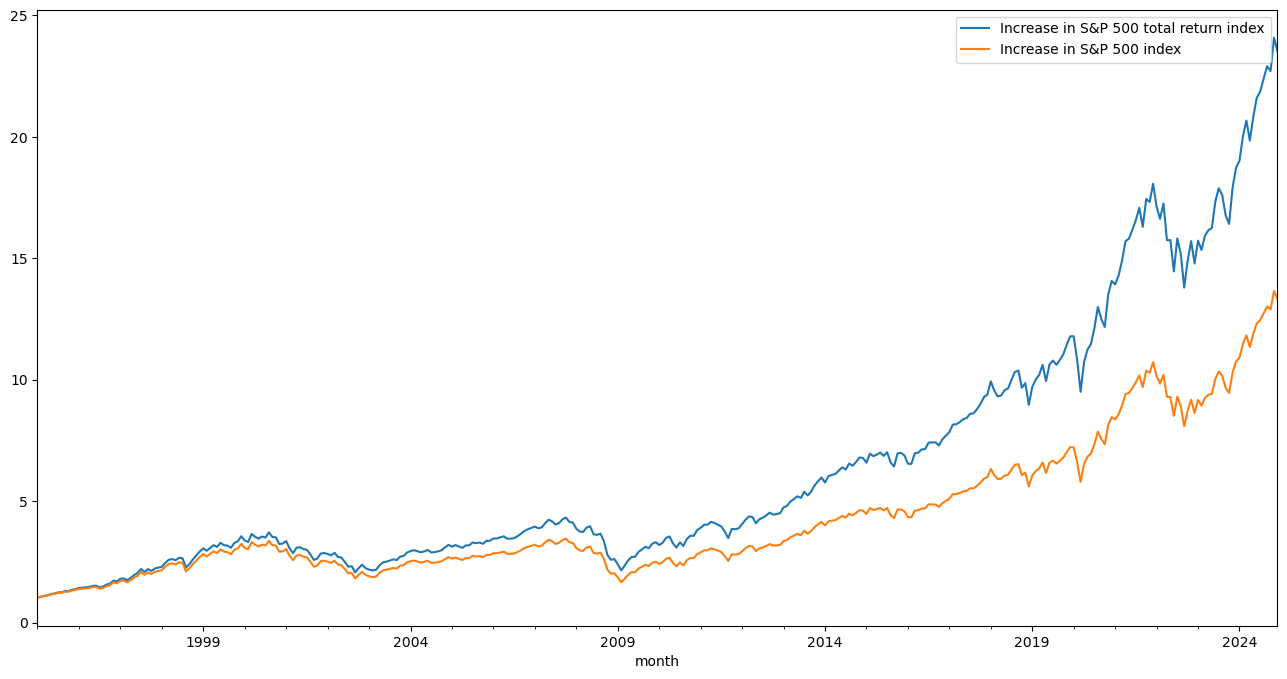

In [16]:
comparison_figure

<center><h2>Returns on investing in fixed income</h2></center>

## Bloomberg/Barclays aggregate bond index

- The best-known US bond market index. The formal name has
changed several times. It is generally just called the “Agg.”

- It reflects a value-weighted portfolio of a broad range of
fixed-income securities. Like most bond indexes, it is a “total
return” index, meaning it does include coupon reinvestment.

- But unlike stocks, it is not obvious which securities to include.
Currently it’s mostly Treasuries, MBS, and investment-grade corporate.
But this is always a source of debate and controversy.
For example, some argue for adding munis and junk bonds.

- It’s also not obvious if the portfolio represented by this strategy
is really the correct benchmark for investors to use.

- Many basic questions remain open about portfolio management
and performance assessment with fixed income.

<center>
<img src="https://wgjm1986.github.io/FIN323/Module%201/Week%202%20-%20Investment%20returns%2C%20portfolios%2C%20and%20indexes/agg_components_small.png" width="1200px" />
</center>

## AGG ETF historical performance

In [17]:
%%capture
AGG_figure,ax = plt.subplots()
(1+AGG['ret'][:'2022']).cumprod().plot(ax=ax,legend=True,label='AGG total return')
(1+AGG['retx'][:'2022']).cumprod().plot(ax=ax,legend=True,label='AGG price return')

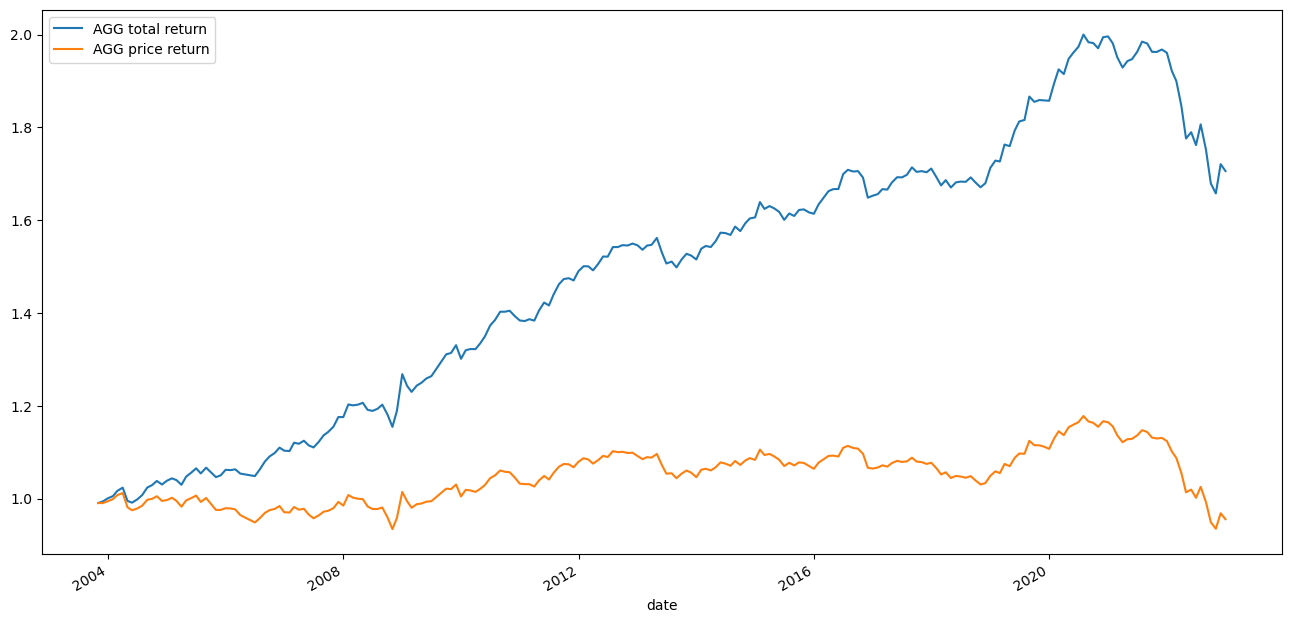

In [18]:
AGG_figure

(This almost identical to the performance of the index itself. See discussion of ETFs next week.)